# Vehicle detection

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label

/Users/aman/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
car_images1 = glob.glob('./vehicles/GTI_Far/image*.png')
car_images2 = glob.glob('./vehicles/GTI_Left/image*.png')
car_images3 = glob.glob('./vehicles/GTI_MiddleClose/image*.png')
car_images4 = glob.glob('./vehicles/GTI_Right/image*.png')
car_images5 = glob.glob('./vehicles/KITTI_extracted/*.png')

non_car_images1 = glob.glob('./non-vehicles/GTI/image*.png')
non_car_images2 = glob.glob('./non-vehicles/Extras/extra*.png')

car_images = car_images1 + car_images2 + car_images3 + car_images4 + car_images5
non_car_images = non_car_images1 + non_car_images2

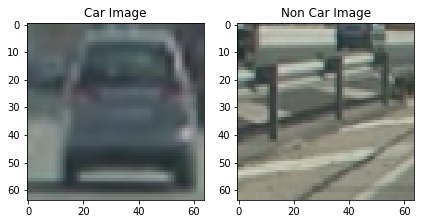

In [33]:
car_image = mpimg.imread(car_images[7])
non_car_image = mpimg.imread(non_car_images[7])
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Car Image')
plt.subplot(122)
plt.imshow(non_car_image)
plt.title('Non Car Image')
fig.tight_layout()

In [3]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

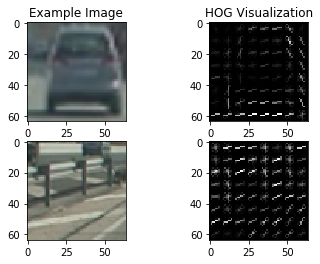

In [48]:
# Read in the image
gray_car = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)
gray_non_car = cv2.cvtColor(non_car_image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features_car, hog_image_car = get_hog_features(gray_car, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
features_non_car, hog_image_non_car = get_hog_features(gray_non_car, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(221)
plt.imshow(car_image)
plt.title('Example Image')
plt.subplot(222)
plt.imshow(hog_image_car, cmap='gray')
plt.title('HOG Visualization')
plt.subplot(223)
plt.imshow(non_car_image)
plt.subplot(224)
plt.imshow(hog_image_non_car, cmap='gray')

In [5]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

In [6]:
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [7]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [51]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (8, 8) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
ystart = 400
ystop = None
scale = 1.5

In [9]:
car_features = extract_features(car_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(non_car_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)


/Users/aman/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [10]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [11]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5532


In [12]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

41.59 Seconds to train SVC...
Test Accuracy of SVC =  0.9932


In [13]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, vis=False):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    car_plots = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box = ((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart))
                car_plots.append(box)
                if vis:
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,255,0),6) 
    if vis:
        return car_plots, draw_img
    else:
        return car_plots

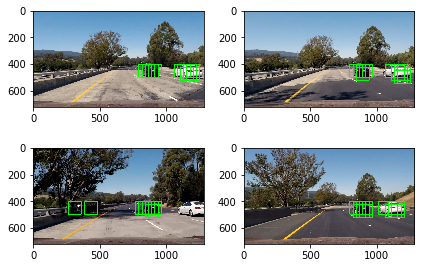

In [65]:
%matplotlib inline
image1 = mpimg.imread('./test_images/test1.jpg')
image2 = mpimg.imread('./test_images/test4.jpg')
image3 = mpimg.imread('./test_images/test5.jpg')
image4 = mpimg.imread('./test_images/test6.jpg')
car_plots, out_img1 = find_cars(image1, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, vis=True)
car_plots, out_img2 = find_cars(image2, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, vis=True)
car_plots, out_img3 = find_cars(image3, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, vis=True)
car_plots, out_img4 = find_cars(image4, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, vis=True)
fig = plt.figure()
plt.subplot(221)
plt.imshow(out_img1)
plt.subplot(222)
plt.imshow(out_img2)
plt.subplot(223)
plt.imshow(out_img3)
plt.subplot(224)
plt.imshow(out_img4)
fig.tight_layout()

In [15]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [16]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [17]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image
    return img

In [23]:
def final_pipeline(image, vis=False):
    car_plots = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    # print(car_plots)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, car_plots)
    
    heatmaps.append(heat)
    avg_heat = sum(heatmaps) / len(heatmaps)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(avg_heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    if vis:
        return draw_img, heatmap
    else:
        return draw_img

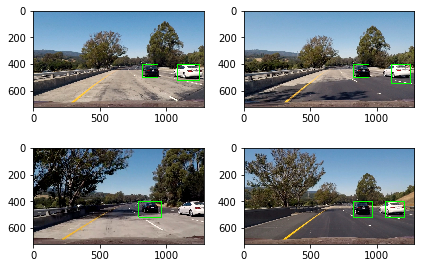

In [64]:
heatmaps = collections.deque(maxlen=1)
draw_img1 = final_pipeline(image1)
draw_img2 = final_pipeline(image2)
draw_img3 = final_pipeline(image3)
draw_img4 = final_pipeline(image4)
fig = plt.figure()
plt.subplot(221)
plt.imshow(draw_img1)
plt.subplot(222)
plt.imshow(draw_img2)
plt.subplot(223)
plt.imshow(draw_img3)
plt.subplot(224)
plt.imshow(draw_img4)
fig.tight_layout()

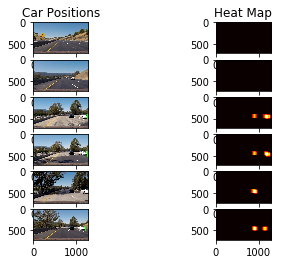

In [70]:
heatmaps = collections.deque(maxlen=1)
image1 = mpimg.imread('./test_images/test2.jpg')
image2 = mpimg.imread('./test_images/test3.jpg')
image3 = mpimg.imread('./test_images/test1.jpg')
image4 = mpimg.imread('./test_images/test4.jpg')
image5 = mpimg.imread('./test_images/test5.jpg')
image6 = mpimg.imread('./test_images/test6.jpg')

draw_img1, heatmap1 = final_pipeline(image1, vis=True)
draw_img2, heatmap2 = final_pipeline(image2, vis=True)
draw_img3, heatmap3 = final_pipeline(image3, vis=True)
draw_img4, heatmap4 = final_pipeline(image4, vis=True)
draw_img5, heatmap5 = final_pipeline(image5, vis=True)
draw_img6, heatmap6 = final_pipeline(image6, vis=True)

fig = plt.figure()
plt.subplot(621)
plt.imshow(draw_img1)
plt.title('Car Positions')
plt.subplot(622)
plt.imshow(heatmap1, cmap='hot')
plt.title('Heat Map')
plt.subplot(623)
plt.imshow(draw_img2)
plt.subplot(624)
plt.imshow(heatmap2, cmap='hot')
plt.subplot(625)
plt.imshow(draw_img3)
plt.subplot(626)
plt.imshow(heatmap3, cmap='hot')
plt.subplot(627)
plt.imshow(draw_img4)
plt.subplot(628)
plt.imshow(heatmap4, cmap='hot')
plt.subplot(629)
plt.imshow(draw_img5)
plt.subplot(6,2,10)
plt.imshow(heatmap5, cmap='hot')
plt.subplot(6,2,11)
plt.imshow(draw_img6)
plt.subplot(6,2,12)
plt.imshow(heatmap6, cmap='hot')

In [27]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import cv2
import collections

heatmaps = collections.deque(maxlen=10)

output_video = 'test_video_solution.mp4'
clip2 = VideoFileClip('test_video.mp4')
yellow_clip = clip2.fl_image(final_pipeline)
%time yellow_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video test_video_solution.mp4
[MoviePy] Writing video test_video_solution.mp4


 97%|█████████▋| 38/39 [00:27<00:00,  1.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_solution.mp4 

CPU times: user 25.5 s, sys: 2.16 s, total: 27.6 s
Wall time: 29.4 s


In [34]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import cv2
import collections

heatmaps = collections.deque(maxlen=10)

output_video = 'project_video_solution.mp4'
clip2 = VideoFileClip('project_video.mp4')
yellow_clip = clip2.fl_image(final_pipeline)
%time yellow_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video project_video_solution.mp4
[MoviePy] Writing video project_video_solution.mp4


100%|█████████▉| 1260/1261 [20:07<00:01,  1.42s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_solution.mp4 

CPU times: user 18min 20s, sys: 1min 25s, total: 19min 46s
Wall time: 20min 10s
